# Compare Temperature at 2m between ERA5 and GHCND.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import cftime
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
import geopandas as gpd
from matplotlib import cm
import functions_utils

In [2]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [3]:
lon_min = 250.6
lon_max = 258.5
lat_min = 36.7
lat_max = 41.3

In [4]:
datadir = '/Projects/RAPrototype/GHCND/'

# READ STATIONS DATA

In [5]:
ifile=f'{datadir}/GHCND_Tmin_Tmax_COLORADO.nc'
dso = xr.open_dataset(ifile)
dso = dso.sel(time=slice('1951-01-01','2024-12-31'))
dso['TMIN'] = dso['TMIN'].where(dso['TMIN']>-1000)
dso['TMIN'] = dso['TMIN']/10.* 9/5 + 32 # degreeF instead of 10th of degreeC
dso['TMAX'] = dso['TMAX'].where(dso['TMAX']>-1000)
dso['TMAX'] = dso['TMAX']/10.* 9/5 + 32 # degreeF instead of 10th of degreeC
Otmin = dso['TMIN']
Otmax = dso['TMAX']
units = f'$\degree$F'

# Get name of stations

In [6]:
Tstation = dso['station'].data
ds=dso


In [7]:
dsheight=xr.open_dataset('https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/60s/60s_surface_elev_netcdf/ETOPO_2022_v1_60s_N90W180_surface.nc')
dsheight = dsheight.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min-360,lon_max-360))

In [8]:
Tlabel = ['Grand Junction','Fraser','Sterling','Durango','Colorado Springs','Pueblo','Fruita', 'Hayden','Springfield','Denver']

/tmp/ipykernel_1916308/3763825014.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',len(ds['station']))


Text(0.5, 1.0, 'GHNCD stations - Colorado')

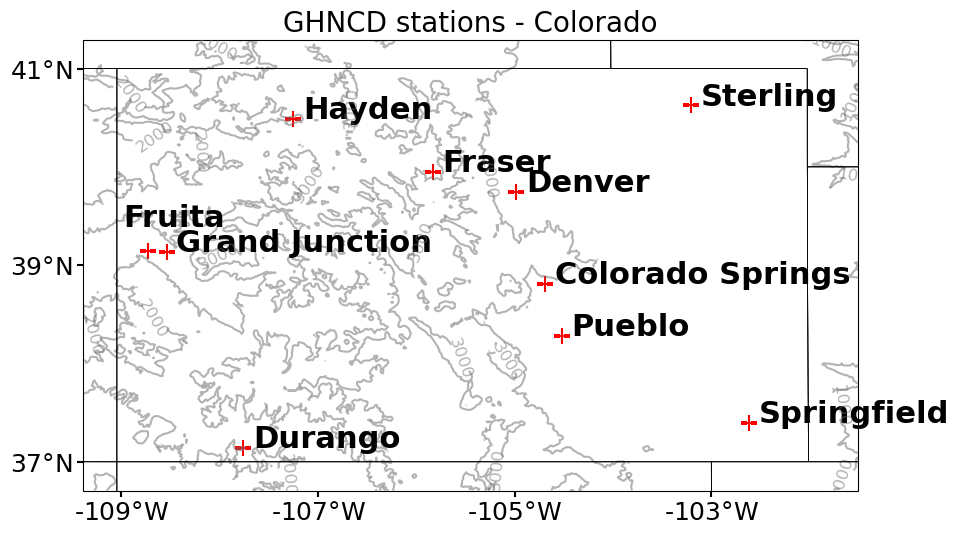

In [9]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
colors=cm.get_cmap('turbo',len(ds['station']))
#colors=cm.get_cmap('turbo',10)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,11),subplot_kw={'projection':proj})
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    ax.scatter(ds['longitude'][ip]+360,ds['latitude'][ip],marker='+',color='r',s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    ax.scatter(ds['longitude'][ip]+360,ds['latitude'][ip],marker='+',color='r',s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.set_title('GHNCD stations - Colorado',fontsize=20)

# READ ERA5 interpolated on GHCND 's stations.

In [10]:
dsEtmin=xr.open_dataset(f'{datadir}/era5_daily_tmin_GHCND_CO.nc')
dsEtmin = dsEtmin.sel(time=ds['time'],drop=True)
dsEtmax=xr.open_dataset(f'{datadir}/era5_daily_tmax_GHCND_CO.nc')
dsEtmax = dsEtmax.sel(time=ds['time'],drop=True)
Etmin = dsEtmin['Tmin']* 9/5 + 32 # degC to degF
Etmax = dsEtmax['Tmax']* 9/5 + 32 # degC to degF

# READ NClimDrid interpolated on GHCND 's stations.

In [11]:
dsNtmin=xr.open_dataset(f'{datadir}/NClimGridDaily_daily_tmin_GHCND_CO.nc')
dsNtmin = dsNtmin.sel(time=ds['time'],drop=True)
dsNtmax=xr.open_dataset(f'{datadir}/NClimGridDaily_daily_tmax_GHCND_CO.nc')
dsNtmax = dsNtmax.sel(time=ds['time'],drop=True)

Ntmin = dsNtmin['Tmin']* 9/5 + 32 # degC to degF
Ntmax = dsNtmax['Tmax']* 9/5 + 32 # degC to degF

# Time matching GHCND and ERA5

In [ ]:
#obs = functions_utils.remove_outliers_seasons(ds['TAVG'],2)

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [12]:
masktmin = xr.where(np.isnan(Otmin)==False,1,0)
masktmax = xr.where(np.isnan(Otmax)==False,1,0)

In [13]:
Etmin = Etmin.where(masktmin==1)
Ntmin = Ntmin.where(masktmin==1)
Etmax = Etmax.where(masktmax==1)
Ntmax = Ntmax.where(masktmax==1)

In [14]:
Etmin['time'] = Otmin['time']
Etmin['station'] = Otmin['station']
Ntmin['time'] = Otmin['time']
Ntmin['station'] = Otmin['station']
Etmax['time'] = Otmin['time']
Etmax['station'] = Otmin['station']
Ntmax['time'] = Otmin['time']
Ntmax['station'] = Otmin['station']

In [15]:
rmse_OEmin = xr.zeros_like(Otmin.mean('time'))*np.nan ; rmse_ONmin = xr.zeros_like(Otmin.mean('time'))*np.nan
corr_OEmin = xr.zeros_like(Otmin.mean('time'))*np.nan ; corr_ONmin = xr.zeros_like(Otmin.mean('time'))*np.nan
mbia_OEmin = xr.zeros_like(Otmin.mean('time'))*np.nan ; mbia_ONmin = xr.zeros_like(Otmin.mean('time'))*np.nan

rmse_OEmax = xr.zeros_like(Otmax.mean('time'))*np.nan ; rmse_ONmax = xr.zeros_like(Otmax.mean('time'))*np.nan
corr_OEmax = xr.zeros_like(Otmax.mean('time'))*np.nan ; corr_ONmax = xr.zeros_like(Otmax.mean('time'))*np.nan
mbia_OEmax = xr.zeros_like(Otmax.mean('time'))*np.nan ; mbia_ONmax = xr.zeros_like(Otmax.mean('time'))*np.nan 

In [16]:
aOtmin = (Otmin.groupby('time.day') - Otmin.groupby('time.day').mean('time'))
aEtmin = (Etmin.groupby('time.day') - Etmin.groupby('time.day').mean('time'))
aNtmin = (Ntmin.groupby('time.day') - Ntmin.groupby('time.day').mean('time'))

aOtmax = (Otmax.groupby('time.day') - Otmax.groupby('time.day').mean('time'))
aEtmax = (Etmax.groupby('time.day') - Etmax.groupby('time.day').mean('time'))
aNtmax = (Ntmax.groupby('time.day') - Ntmax.groupby('time.day').mean('time'))

# PLOT RMSE

In [17]:
for ip in range(0,len(ds['station'])):
    rmse_OEmin[ip] = np.sqrt(np.nanmean(Otmin.isel(station=ip) - Etmin.isel(station=ip))**2)
    rmse_OEmax[ip] = np.sqrt(np.nanmean(Otmax.isel(station=ip) - Etmax.isel(station=ip))**2)
    rmse_ONmin[ip] = np.sqrt(np.nanmean(Otmin.isel(station=ip) - Ntmin.isel(station=ip))**2)
    rmse_ONmax[ip] = np.sqrt(np.nanmean(Otmax.isel(station=ip) - Ntmax.isel(station=ip))**2)    

/tmp/ipykernel_1916308/3016753889.py:2: RuntimeWarning: Mean of empty slice
  rmse_OEmin[ip] = np.sqrt(np.nanmean(Otmin.isel(station=ip) - Etmin.isel(station=ip))**2)
/tmp/ipykernel_1916308/3016753889.py:3: RuntimeWarning: Mean of empty slice
  rmse_OEmax[ip] = np.sqrt(np.nanmean(Otmax.isel(station=ip) - Etmax.isel(station=ip))**2)
/tmp/ipykernel_1916308/3016753889.py:4: RuntimeWarning: Mean of empty slice
  rmse_ONmin[ip] = np.sqrt(np.nanmean(Otmin.isel(station=ip) - Ntmin.isel(station=ip))**2)
/tmp/ipykernel_1916308/3016753889.py:5: RuntimeWarning: Mean of empty slice
  rmse_ONmax[ip] = np.sqrt(np.nanmean(Otmax.isel(station=ip) - Ntmax.isel(station=ip))**2)


In [18]:
print(rmse_OEmin.min(),rmse_OEmin.max())
print(rmse_OEmax.min(),rmse_OEmax.max())

<xarray.DataArray 'TMIN' ()>
array(0.21411013) <xarray.DataArray 'TMIN' ()>
array(7.01110797)
<xarray.DataArray 'TMAX' ()>
array(0.27794037) <xarray.DataArray 'TMAX' ()>
array(5.55926619)


/tmp/ipykernel_1916308/1240859372.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('turbo',len(clevs)-1)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(


Text(0.5, 0.98, 'RMSE GHNCD vs ERA5, Tmin (o) & Tmax (D)')

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux

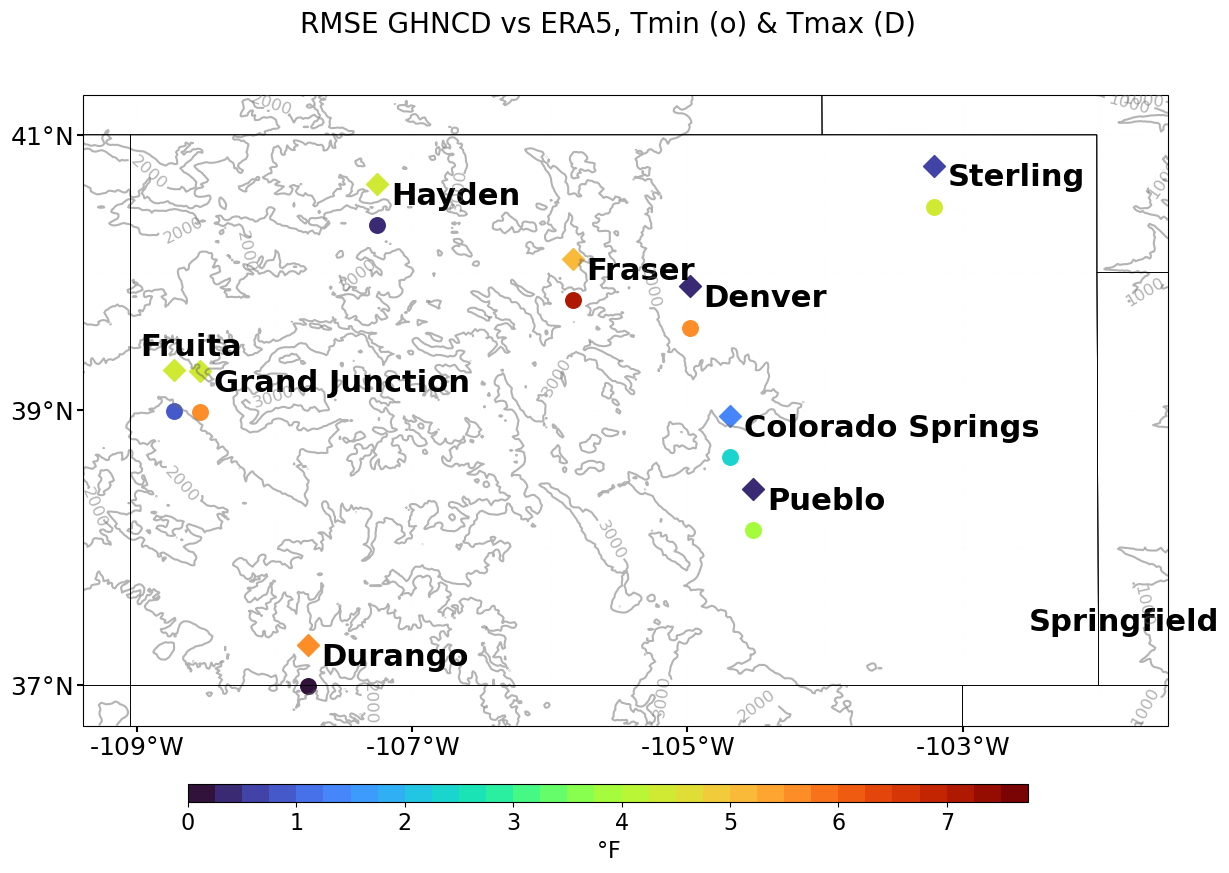

In [19]:
proj=ccrs.PlateCarree()
clevs=np.arange(0,8,0.25)
cmap=cm.get_cmap('turbo',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,9),subplot_kw={'projection':proj})
fig.subplots_adjust(bottom=0.12, top=0.95)
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=rmse_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=rmse_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=rmse_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=rmse_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')


cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('RMSE GHNCD vs ERA5, Tmin (o) & Tmax (D)',fontsize=20)

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(


Text(0.5, 0.98, 'RMSE GHNCD vs NClimGrid, Tmin (o) & Tmax (D)')

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux

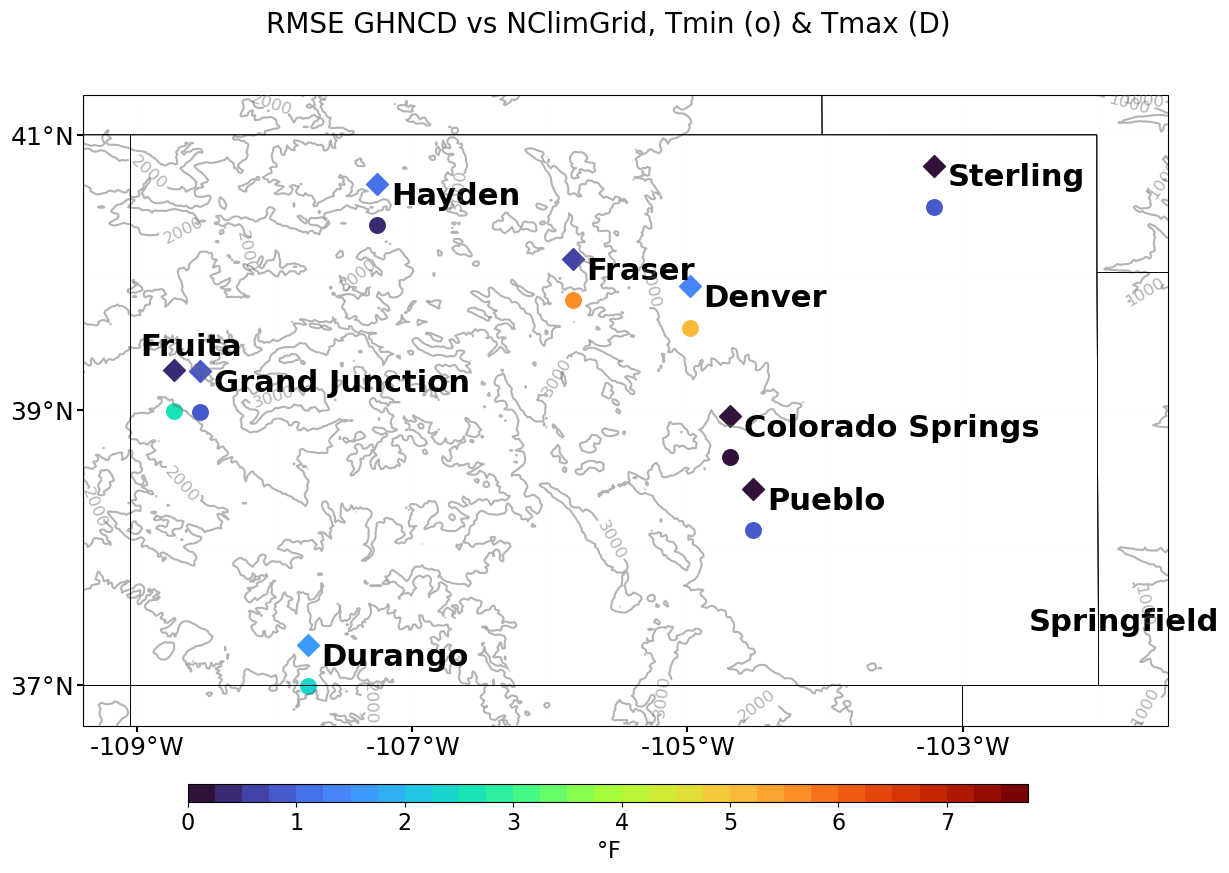

In [ ]:
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,9),subplot_kw={'projection':proj})
fig.subplots_adjust(bottom=0.12, top=0.95)
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=rmse_ONmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=rmse_ONmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=rmse_ONmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=rmse_ONmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('RMSE GHNCD vs NClimGrid, Tmin (o) & Tmax (D)',fontsize=20)

# PLOT Mean Bias

In [35]:
for ip in range(0,len(ds['station'])):
    mbia_OEmin[ip] = np.nanmean(Otmin.isel(station=ip)) - np.nanmean(Etmin.isel(station=ip))
    mbia_OEmax[ip] = np.nanmean(Otmax.isel(station=ip)) - np.nanmean(Etmax.isel(station=ip))
    mbia_ONmin[ip] = np.nanmean(Otmin.isel(station=ip)) - np.nanmean(Ntmin.isel(station=ip))
    mbia_ONmax[ip] = np.nanmean(Otmax.isel(station=ip)) - np.nanmean(Ntmax.isel(station=ip))

/tmp/ipykernel_1916308/3677001769.py:2: RuntimeWarning: Mean of empty slice
  mbia_OEmin[ip] = np.nanmean(Otmin.isel(station=ip)) - np.nanmean(Etmin.isel(station=ip))
/tmp/ipykernel_1916308/3677001769.py:3: RuntimeWarning: Mean of empty slice
  mbia_OEmax[ip] = np.nanmean(Otmax.isel(station=ip)) - np.nanmean(Etmax.isel(station=ip))
/tmp/ipykernel_1916308/3677001769.py:4: RuntimeWarning: Mean of empty slice
  mbia_ONmin[ip] = np.nanmean(Otmin.isel(station=ip)) - np.nanmean(Ntmin.isel(station=ip))
/tmp/ipykernel_1916308/3677001769.py:5: RuntimeWarning: Mean of empty slice
  mbia_ONmax[ip] = np.nanmean(Otmax.isel(station=ip)) - np.nanmean(Ntmax.isel(station=ip))


/tmp/ipykernel_1916308/289004201.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('coolwarm',len(clevs)-1)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(


Text(0.5, 0.98, 'Mean Bias GHNCD vs ERA5, Tmin (o) & Tmax (D)')

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux

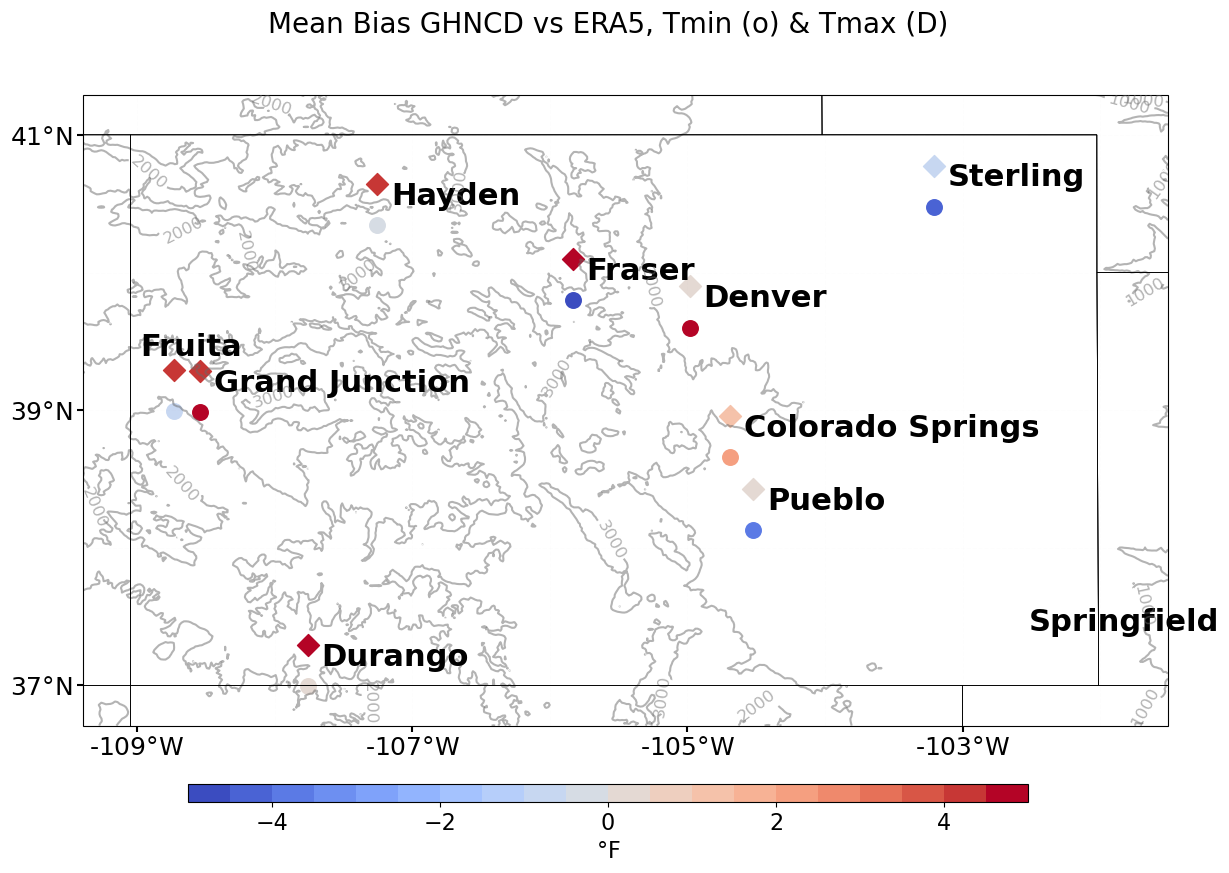

In [37]:
proj=ccrs.PlateCarree()
clevs=np.arange(-5,5.5,0.5)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,9),subplot_kw={'projection':proj})
fig.subplots_adjust(bottom=0.12, top=0.95)
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=mbia_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=mbia_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=mbia_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=mbia_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)

plt.suptitle('Mean Bias GHNCD vs ERA5, Tmin (o) & Tmax (D)',fontsize=20)

/tmp/ipykernel_1916308/726761558.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('coolwarm',len(clevs)-1)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(


Text(0.5, 0.98, 'Mean Bias GHNCD vs NClimGrid, Tmin (o) & Tmax (D)')

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux

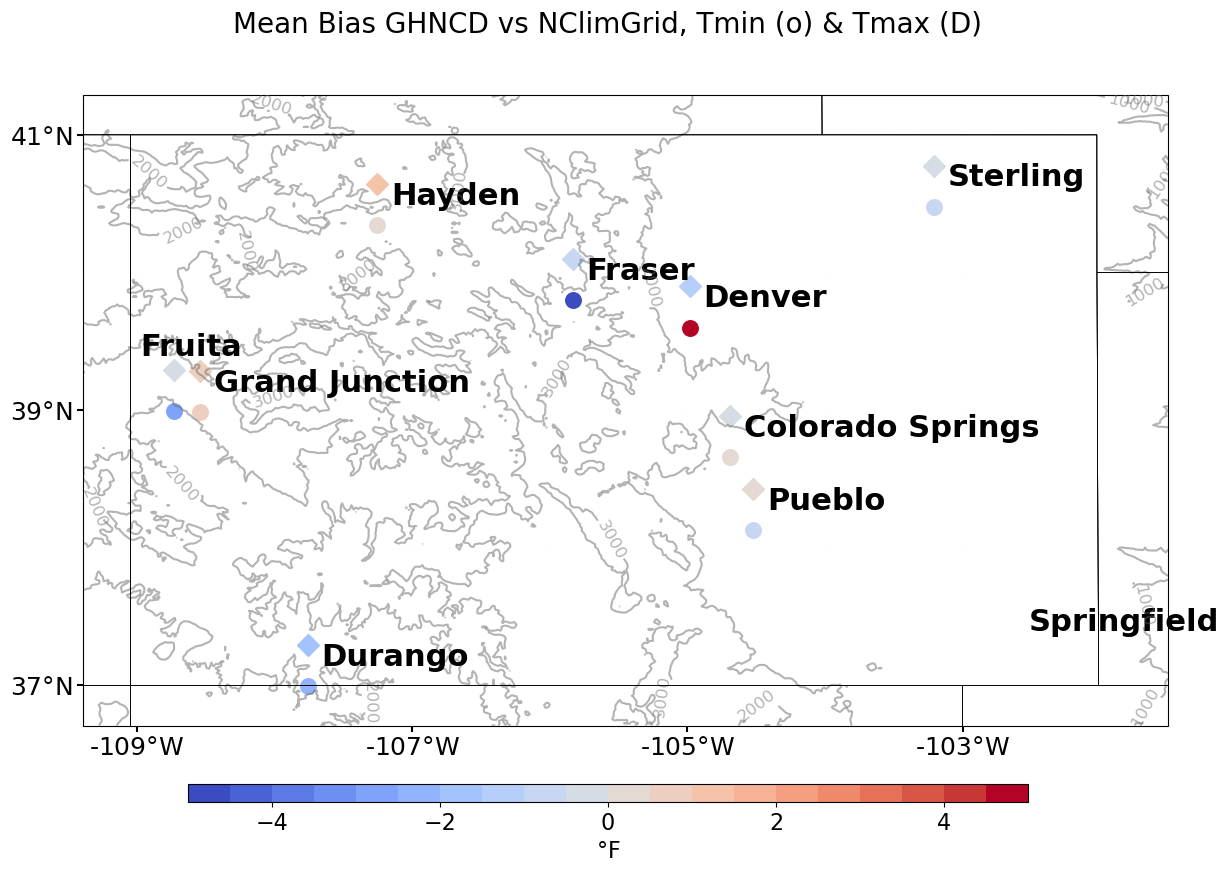

In [ ]:
proj=ccrs.PlateCarree()
clevs=np.arange(-5,5.5,0.5)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,9),subplot_kw={'projection':proj})
fig.subplots_adjust(bottom=0.12, top=0.95)
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=mbia_ONmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=mbia_ONmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=mbia_ONmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=mbia_ONmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Mean Bias GHNCD vs NClimGrid, Tmin (o) & Tmax (D)',fontsize=20)

# PLOT Correlation

In [39]:
for ip in range(0,len(ds['station'])):
    xxxmin = np.where(np.isnan(Otmin.isel(station=ip))==False)[0]
    xxxmax = np.where(np.isnan(Otmax.isel(station=ip))==False)[0]
    corr_OEmin[ip] = np.corrcoef(aOtmin.isel(station=ip)[xxxmin],Etmin.isel(station=ip)[xxxmin])[0][1]
    corr_OEmax[ip] = np.corrcoef(aOtmax.isel(station=ip)[xxxmax],Etmax.isel(station=ip)[xxxmax])[0][1]
    corr_ONmin[ip] = np.corrcoef(aOtmin.isel(station=ip)[xxxmin],Ntmin.isel(station=ip)[xxxmin])[0][1]
    corr_ONmax[ip] = np.corrcoef(aOtmax.isel(station=ip)[xxxmax],Ntmax.isel(station=ip)[xxxmax])[0][1]

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


/tmp/ipykernel_1916308/3652553091.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('Reds',len(clevs)-1)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(


Text(0.5, 0.98, 'Correlation GHNCD vs ERA5, anomaly Tmin (o) & Tmax (D)')

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux

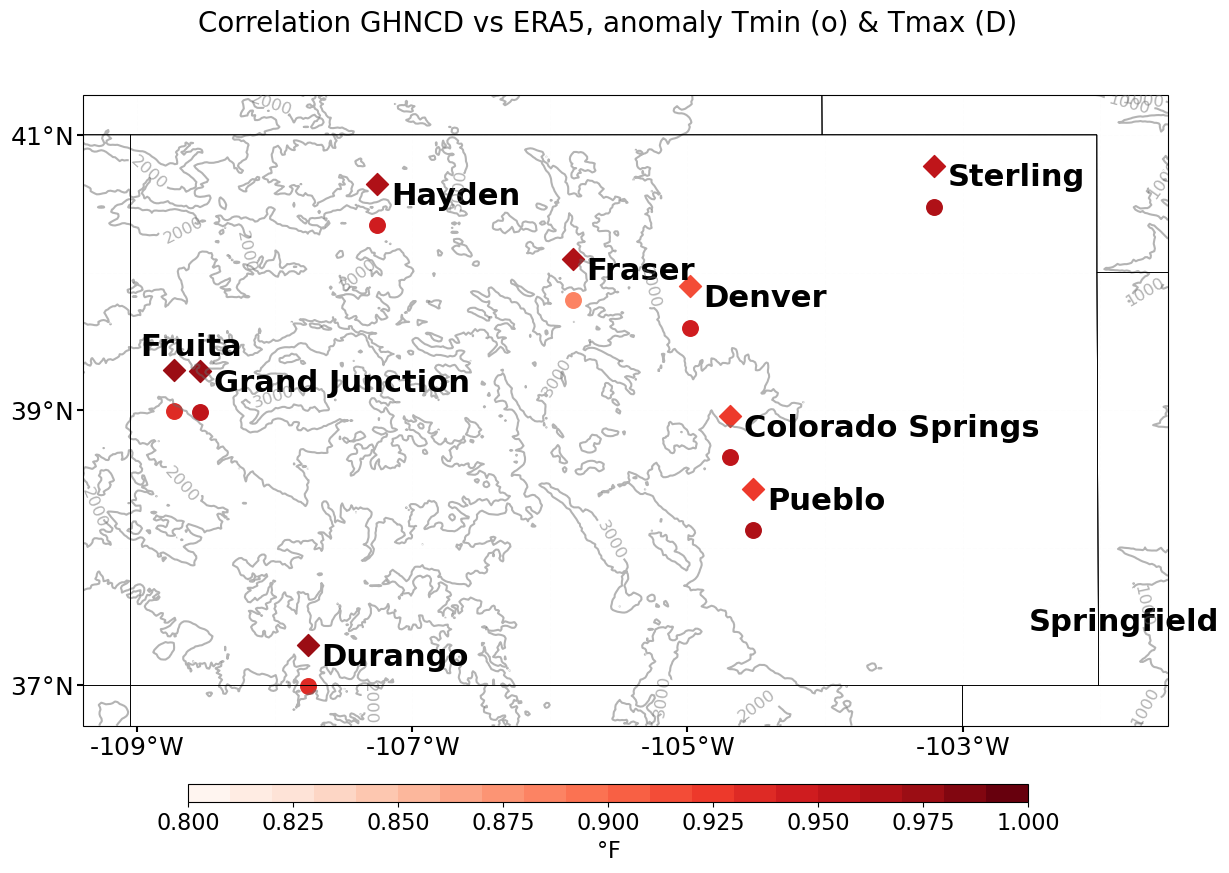

In [44]:
proj=ccrs.PlateCarree()
clevs=np.arange(0.8,1.01,0.01)
cmap=cm.get_cmap('Reds',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,9),subplot_kw={'projection':proj})
fig.subplots_adjust(bottom=0.12, top=0.95)
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=corr_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=corr_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=corr_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=corr_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)

plt.suptitle('Correlation GHNCD vs ERA5, anomaly Tmin (o) & Tmax (D)',fontsize=20)

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(


Text(0.5, 0.98, 'Mean Bias GHNCD vs NClimGrid, anomaly Tmin (o) & Tmax (D)')

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/ghervieux

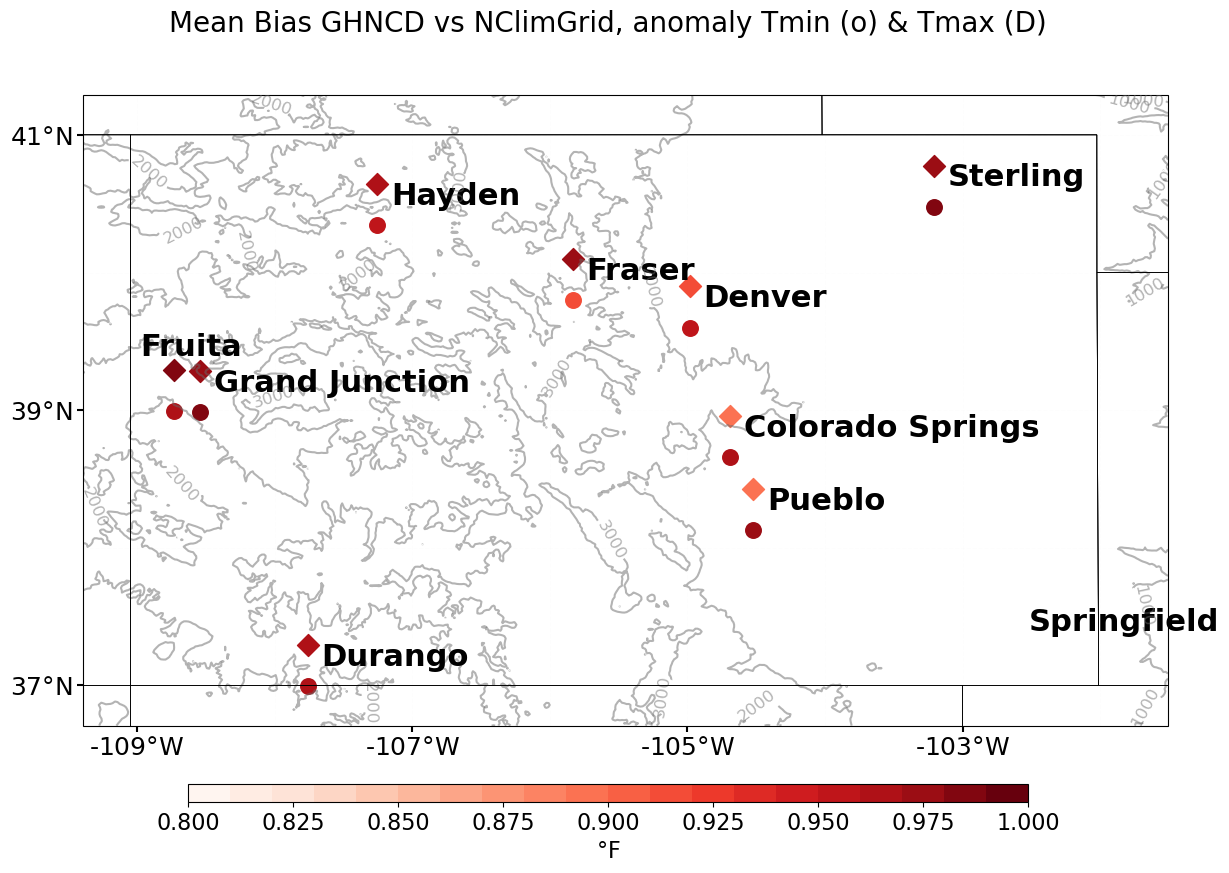

In [45]:
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,9),subplot_kw={'projection':proj})
fig.subplots_adjust(bottom=0.12, top=0.95)
cs=ax.contour(dsheight['lon'],dsheight['lat'],dsheight['z'],levels=np.arange(1000,6000,1000),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)
for ip in range(0,len(ds['station'])):
  if Tlabel[ip] == 'Fruita': 
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=corr_ONmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=corr_ONmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]-0.25,ds['latitude'][ip]+0.25,f'{Tlabel[ip]}',color='k',size=22,weight='bold')
  else:
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.15,c=corr_ONmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=125)
    cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.15,c=corr_ONmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=125)
    ax.text(ds['longitude'][ip]+0.1,ds['latitude'][ip],f'{Tlabel[ip]}',color='k',size=22,weight='bold')

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Mean Bias GHNCD vs NClimGrid, anomaly Tmin (o) & Tmax (D)',fontsize=20)

# Some timeseries

In [22]:
Tip = [0,1,2,3,4,5,6,7,9]

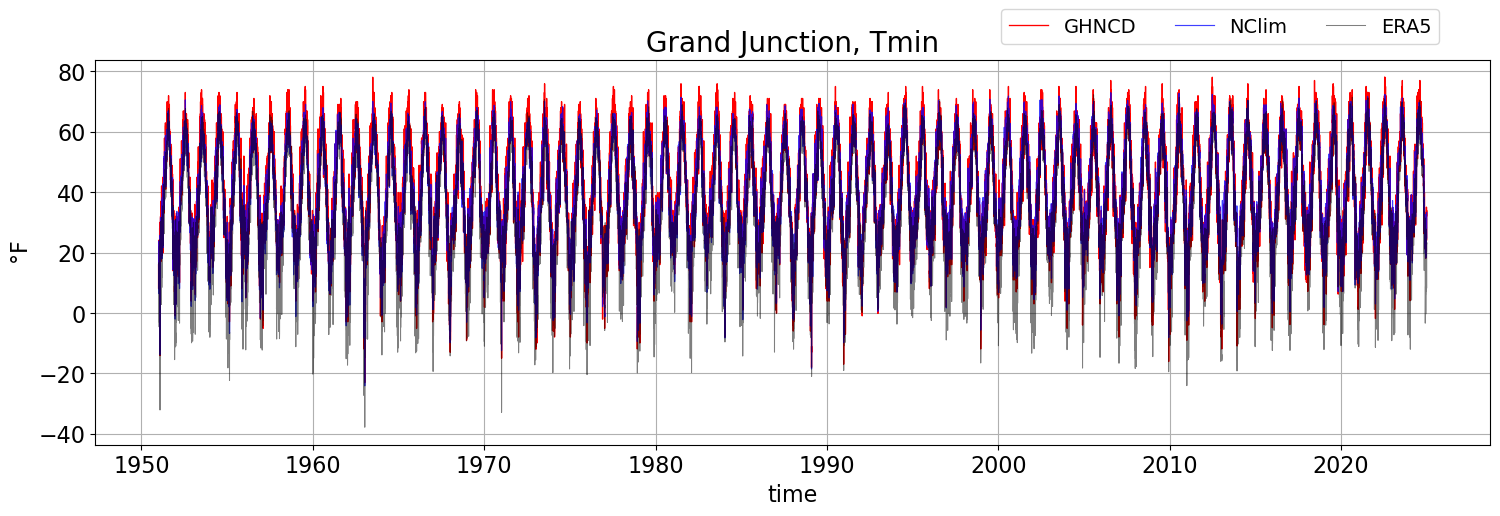

In [85]:
for ip in Tip[0:1]:
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,5))
  ax.plot(ds['time'],Otmin.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  ax.plot(ds['time'],Ntmin.isel(station=ip),color='b',linewidth=0.85,label='NClim',alpha=0.75)
  ax.plot(ds['time'],Etmin.isel(station=ip),color='k',linewidth=0.75,label='ERA5',alpha=0.5)
  ax.tick_params(labelsize=16)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  plt.grid()
  plt.ylabel(units,fontsize=16)  
  plt.xlabel('time',fontsize=16)
  plt.title(f'{Tlabel[ip]}, Tmin',fontsize=20)


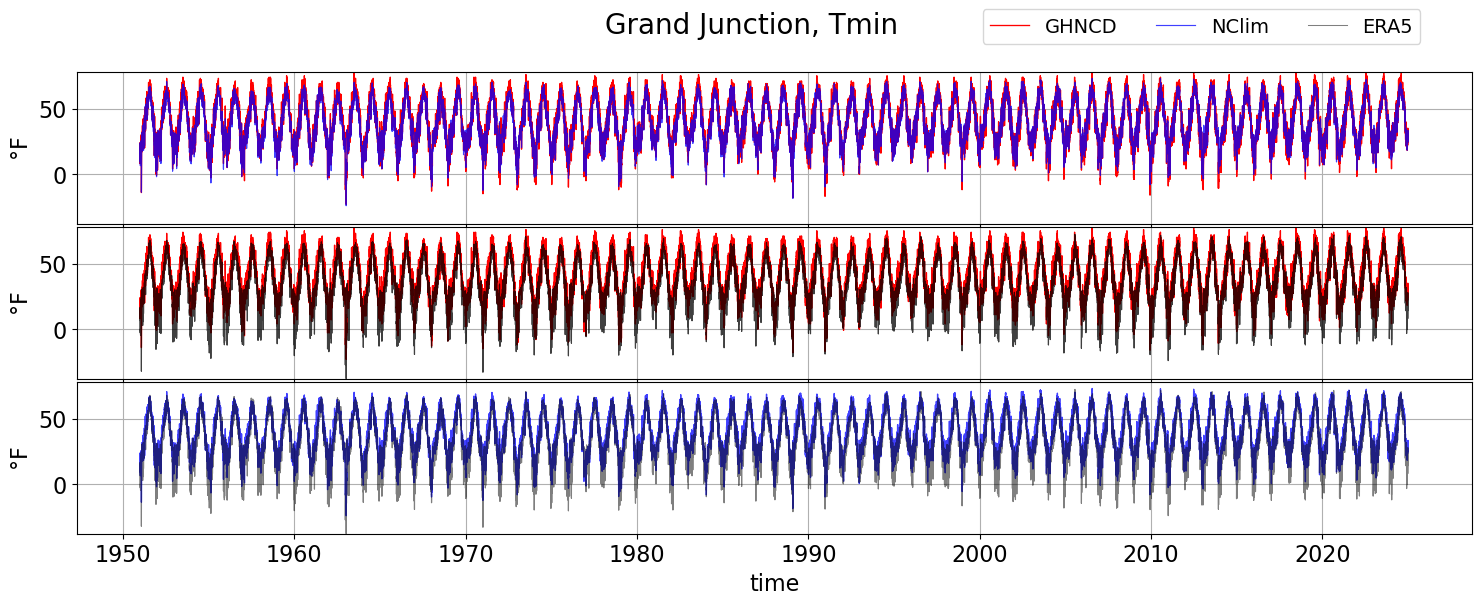

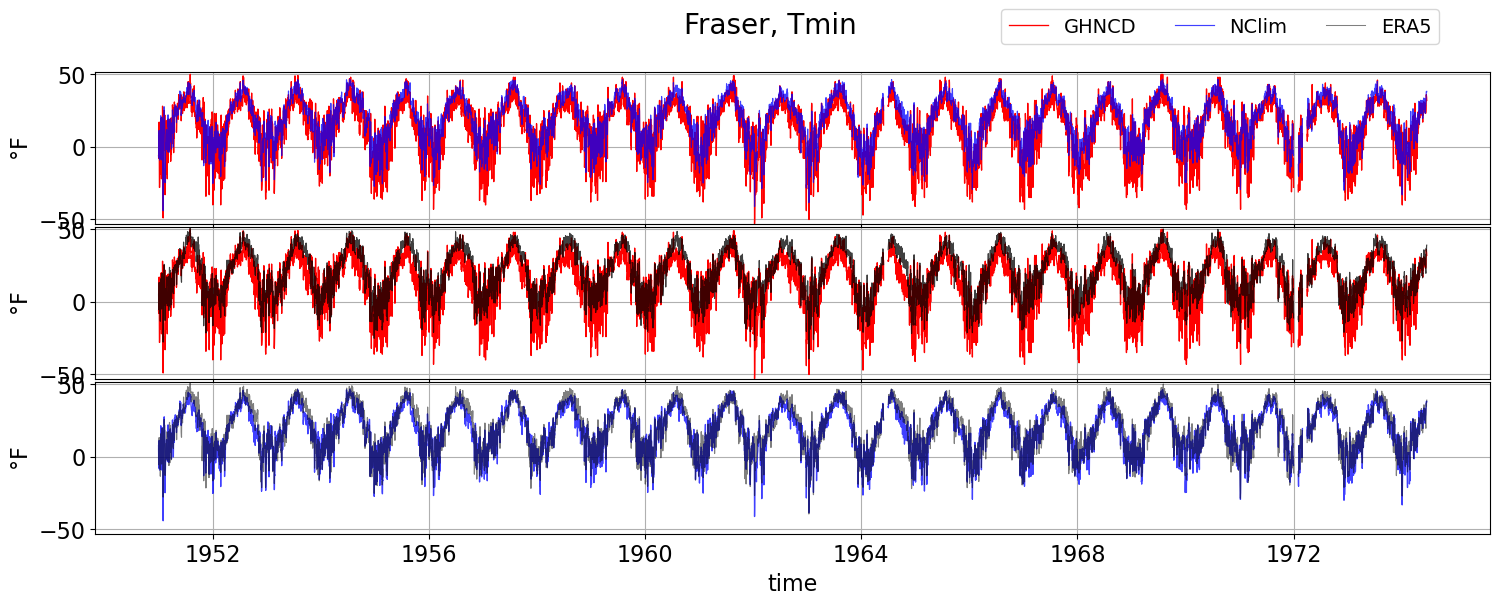

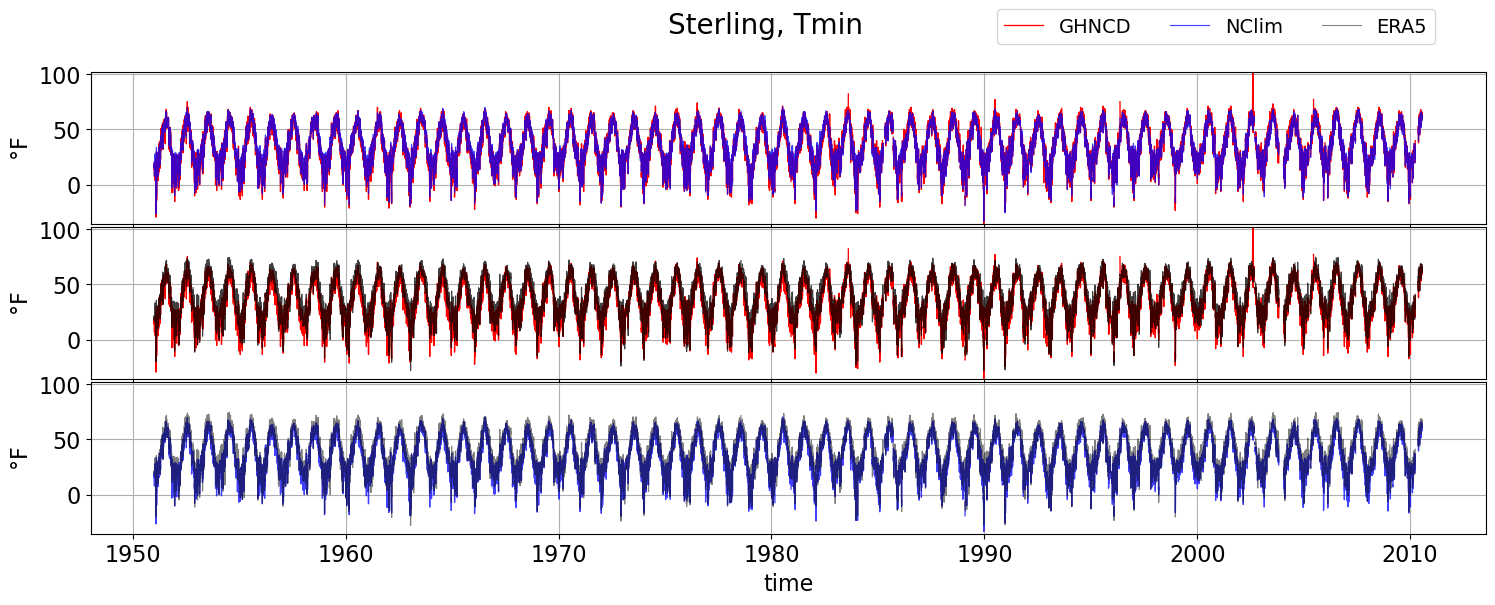

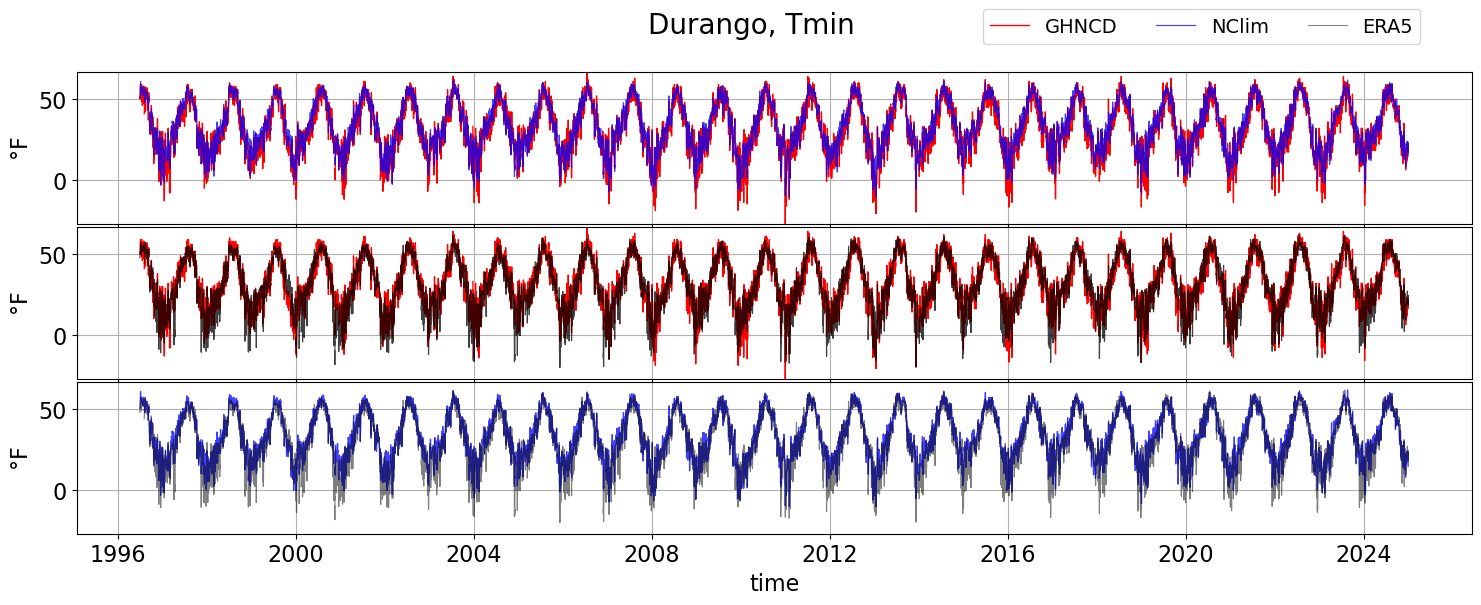

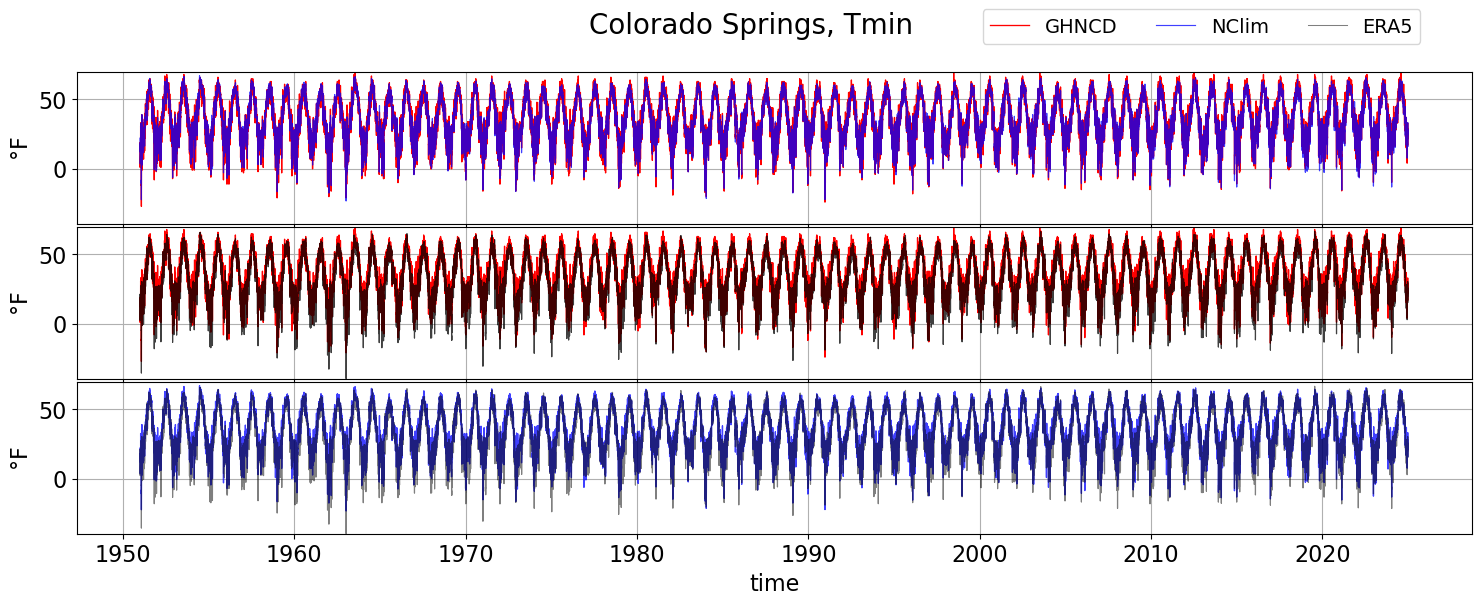

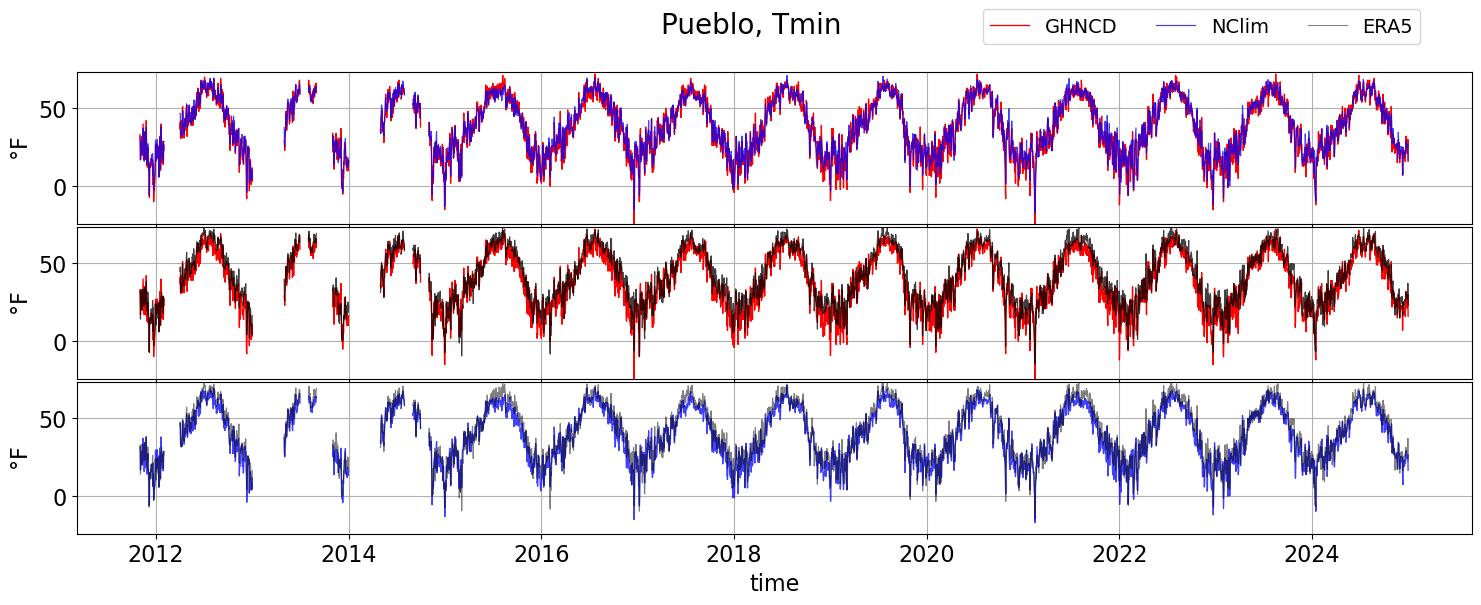

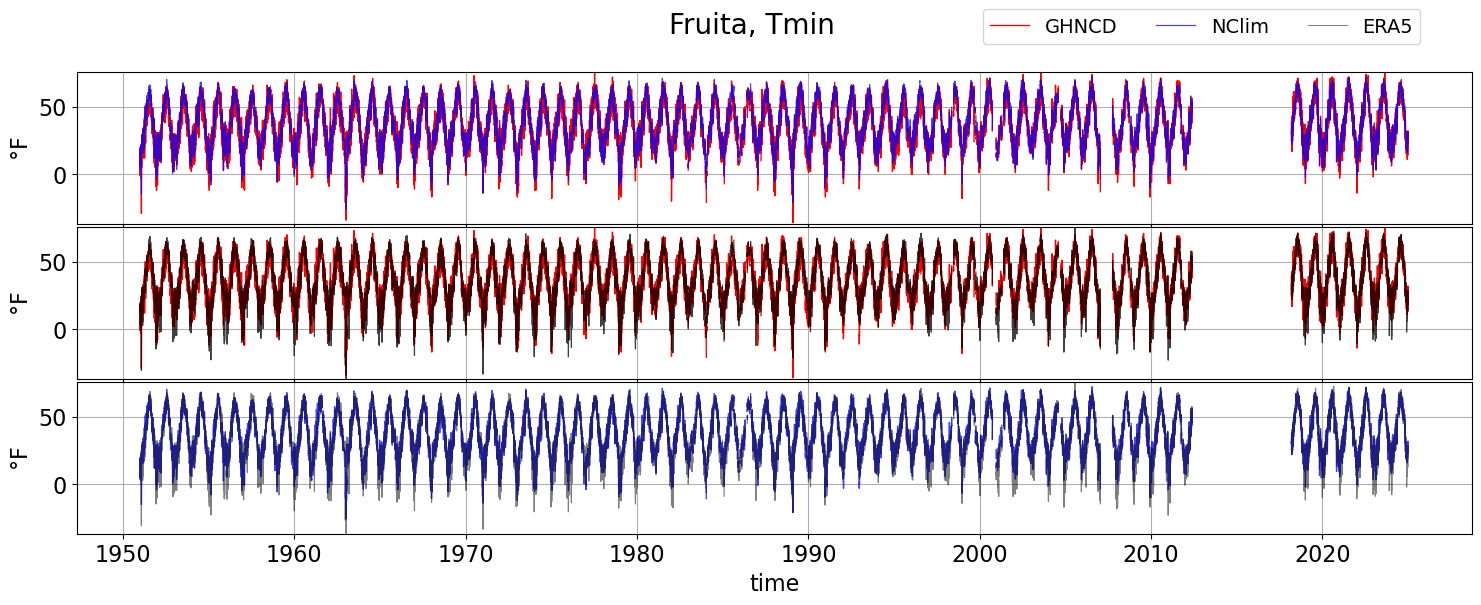

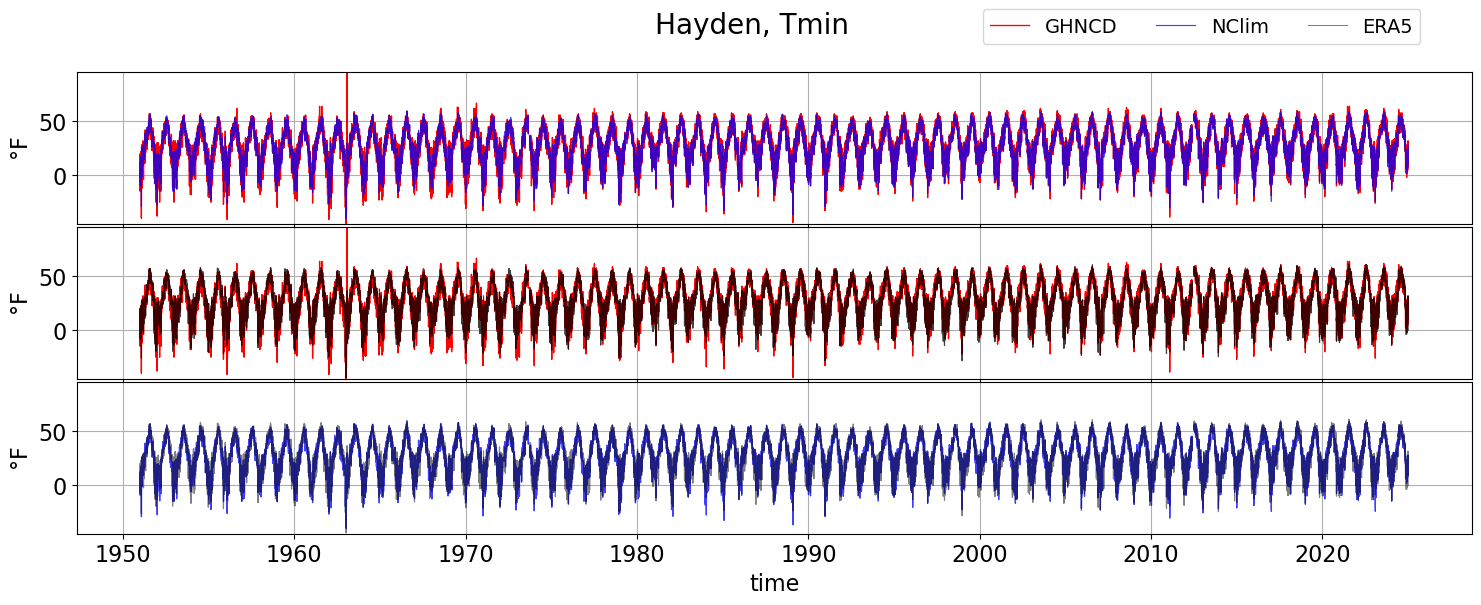

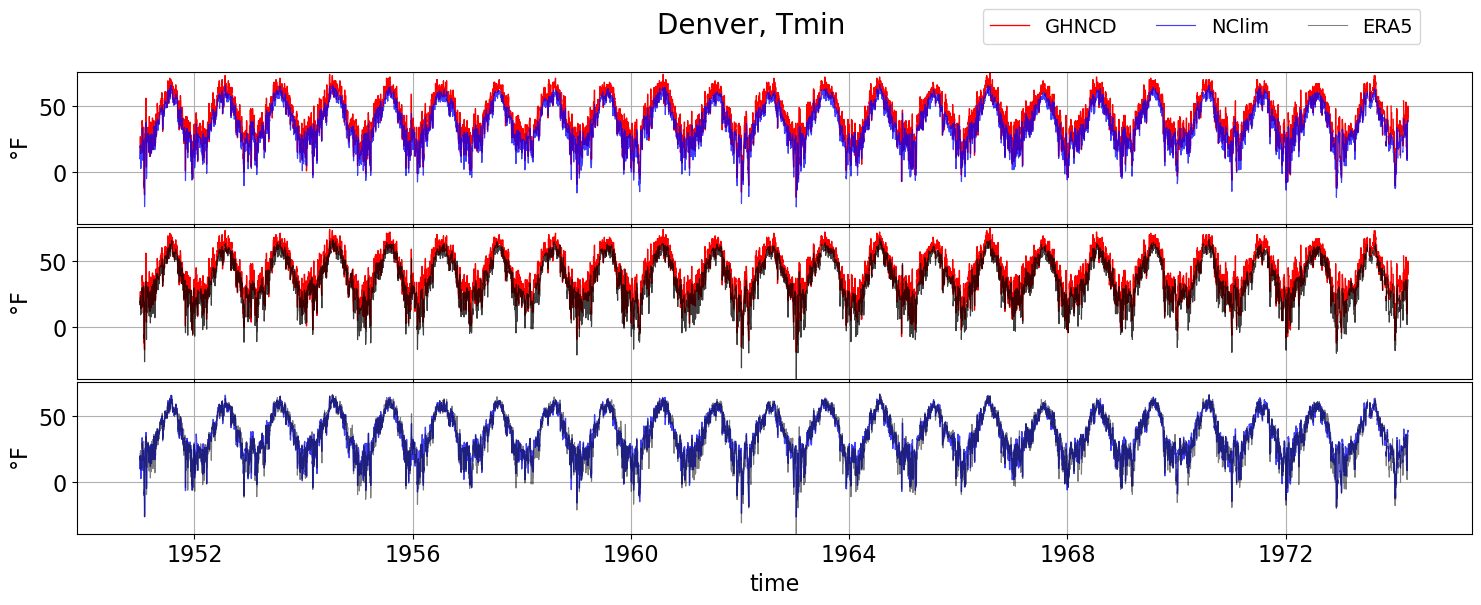

In [90]:
for ip in Tip:
  fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(18,6))
  fig.subplots_adjust(hspace=0.02)
  vmin = min(Otmin.isel(station=ip).min(),Ntmin.isel(station=ip).min(),Etmin.isel(station=ip).min()).data.item()
  vmax = max(Otmin.isel(station=ip).max(),Ntmin.isel(station=ip).max(),Etmin.isel(station=ip).max()).data.item()
  ax[0].plot(ds['time'],Otmin.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  ax[0].plot(ds['time'],Ntmin.isel(station=ip),color='b',linewidth=0.85,label='NClim',alpha=0.75)
  ax[1].plot(ds['time'],Otmin.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  ax[1].plot(ds['time'],Etmin.isel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.75)
  ax[2].plot(ds['time'],Ntmin.isel(station=ip),color='b',linewidth=0.95,label='NClim',alpha=0.75)
  ax[2].plot(ds['time'],Etmin.isel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.5)
  ax[0].set_xticklabels('')
  ax[1].set_xticklabels('')
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  for ix in [0,1,2]:
    ax[ix].set_ylim(vmin,vmax)
    ax[ix].grid()
    ax[ix].tick_params(labelsize=16)
    ax[ix].set_ylabel(units,fontsize=16)   
  plt.xlabel('time',fontsize=16)
  plt.suptitle(f'{Tlabel[ip]}, Tmin',fontsize=20)
  outfile=f'PLOTS/Tmin_daily_ERA5_NClimGrid_CO_'+Tlabel[ip].replace(' ','_')+'.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
  plt.show()

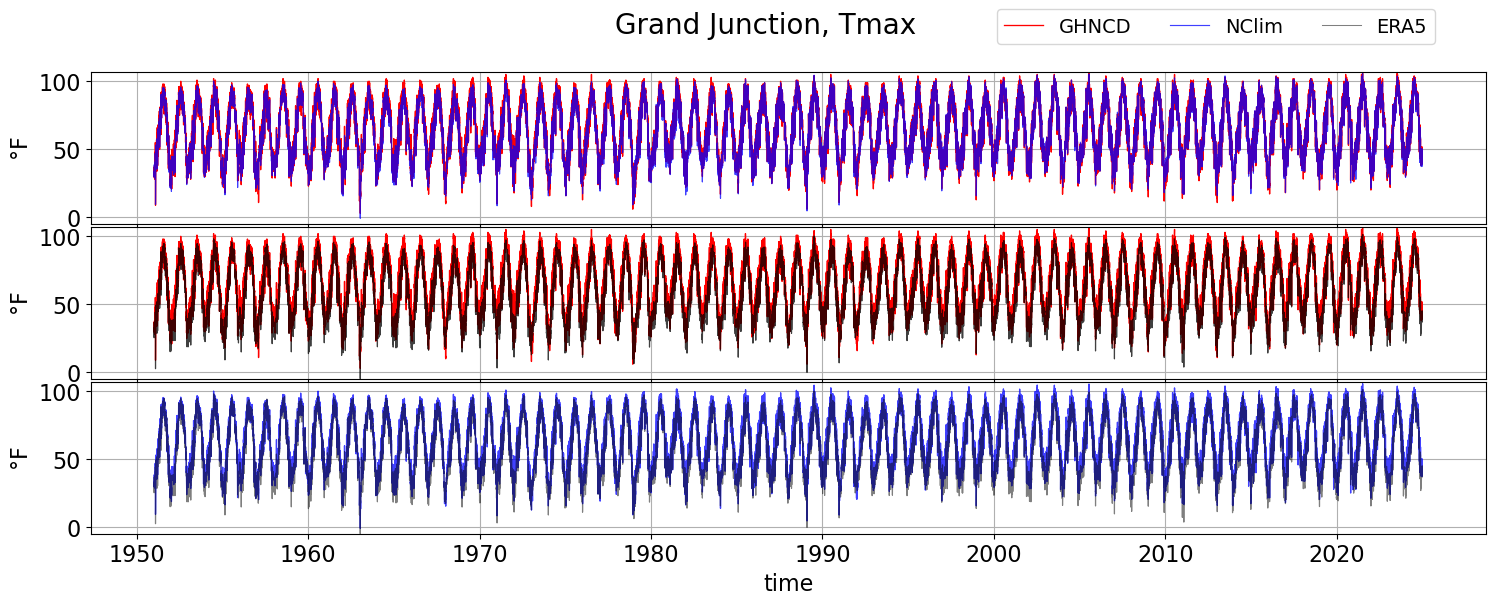

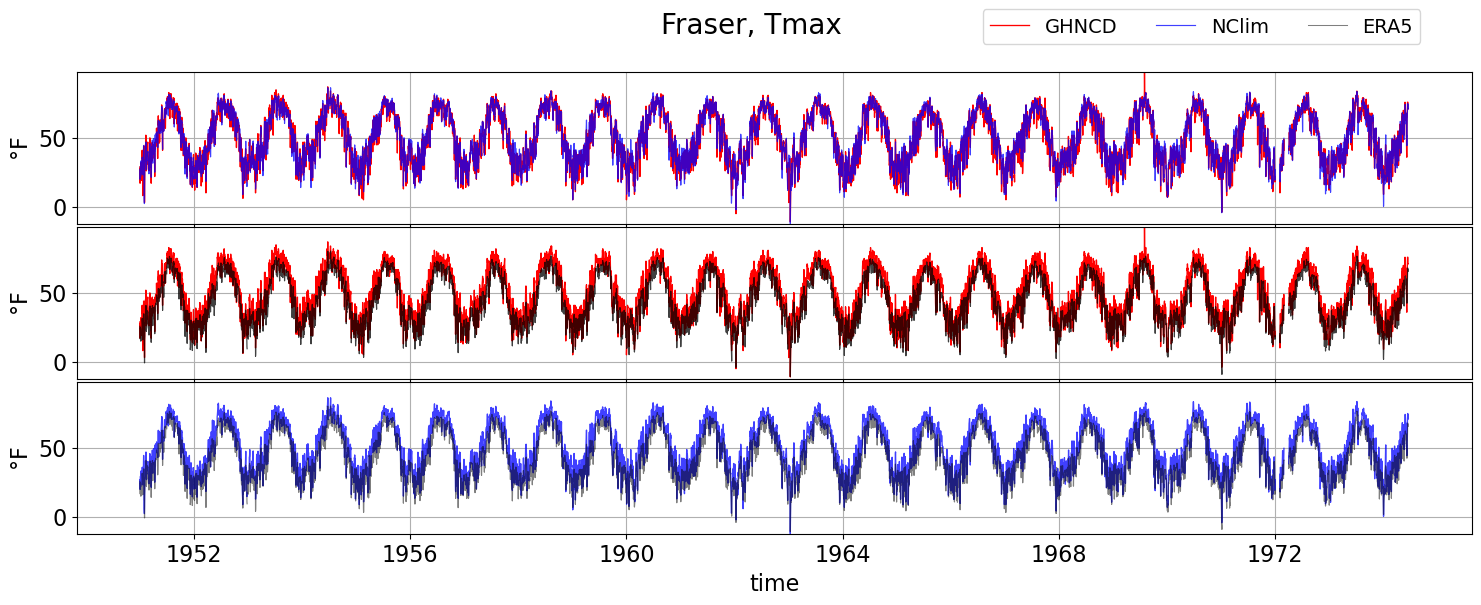

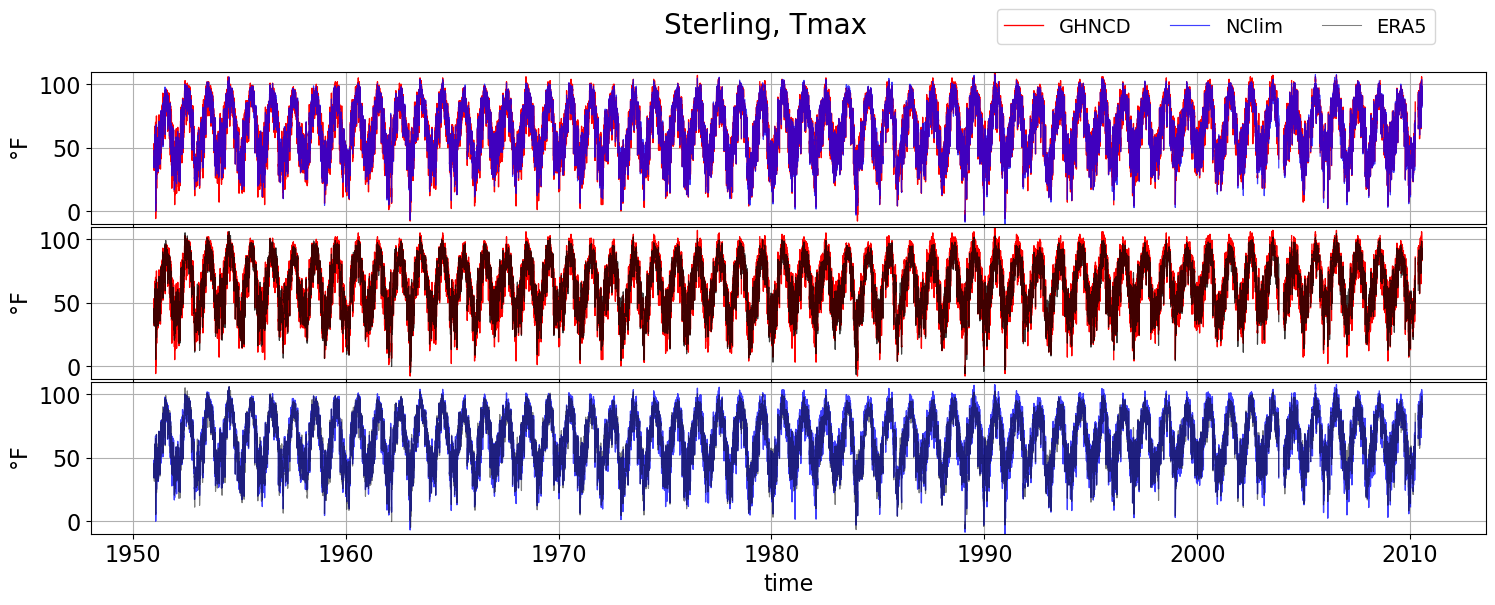

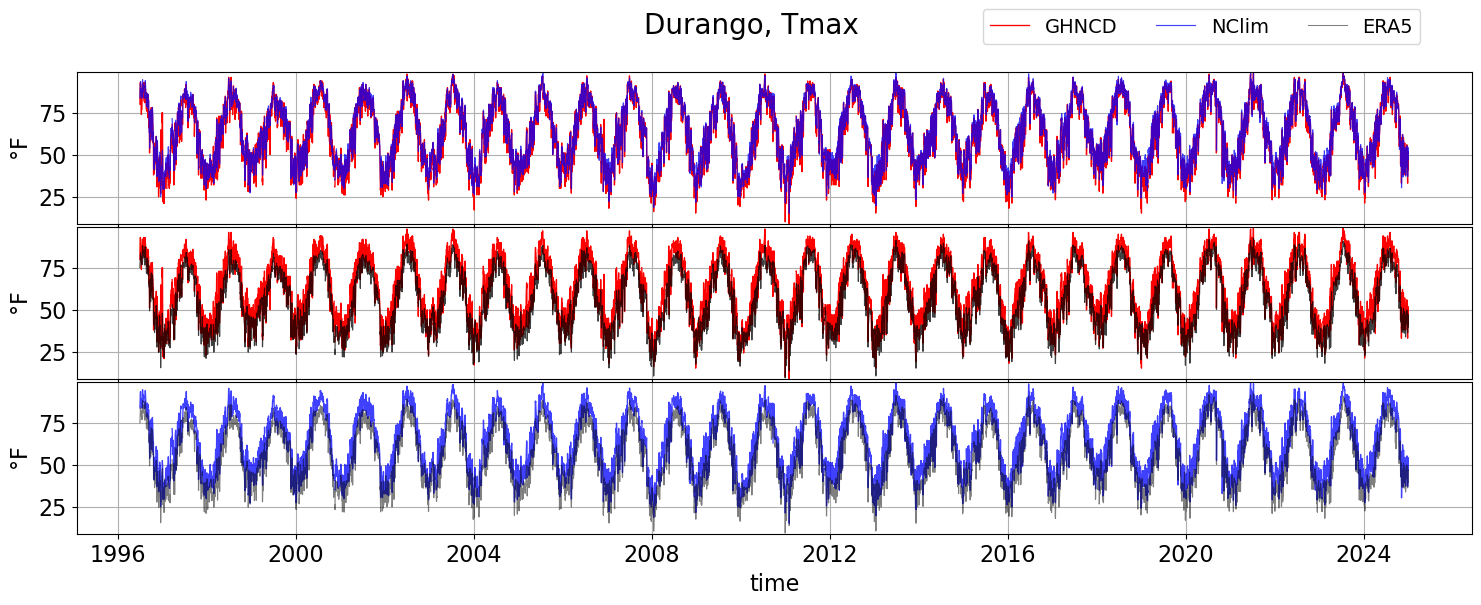

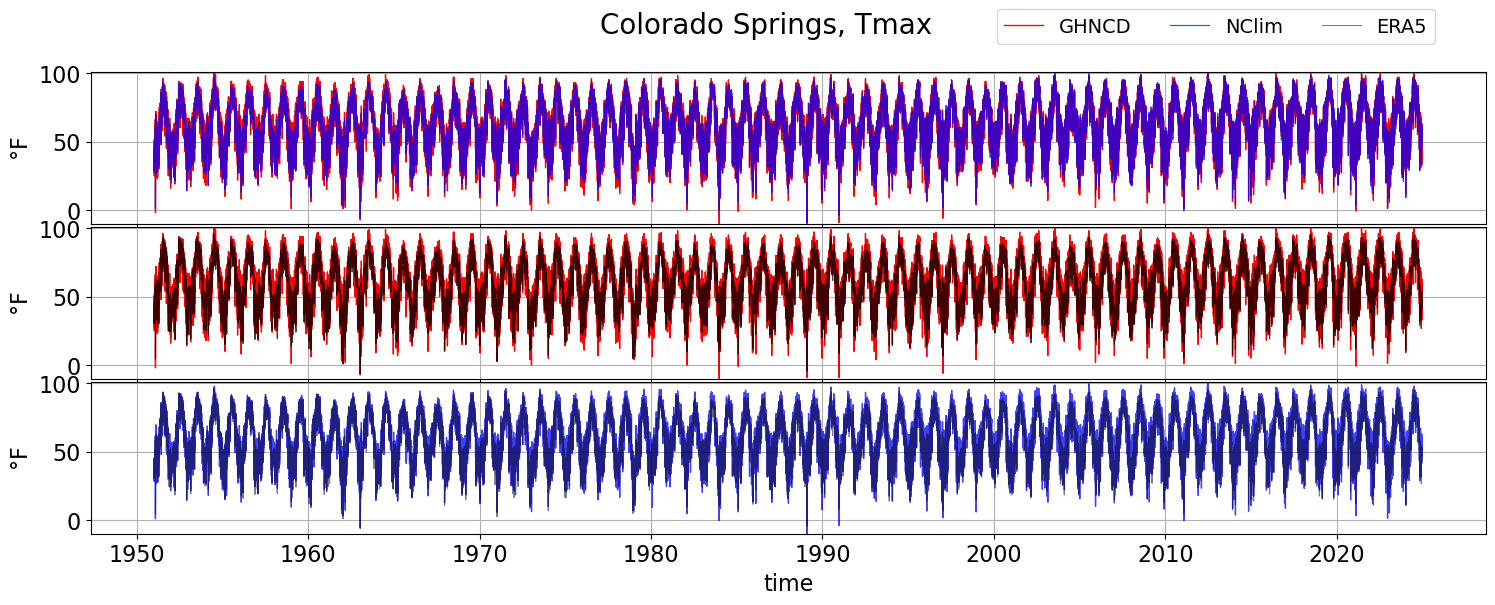

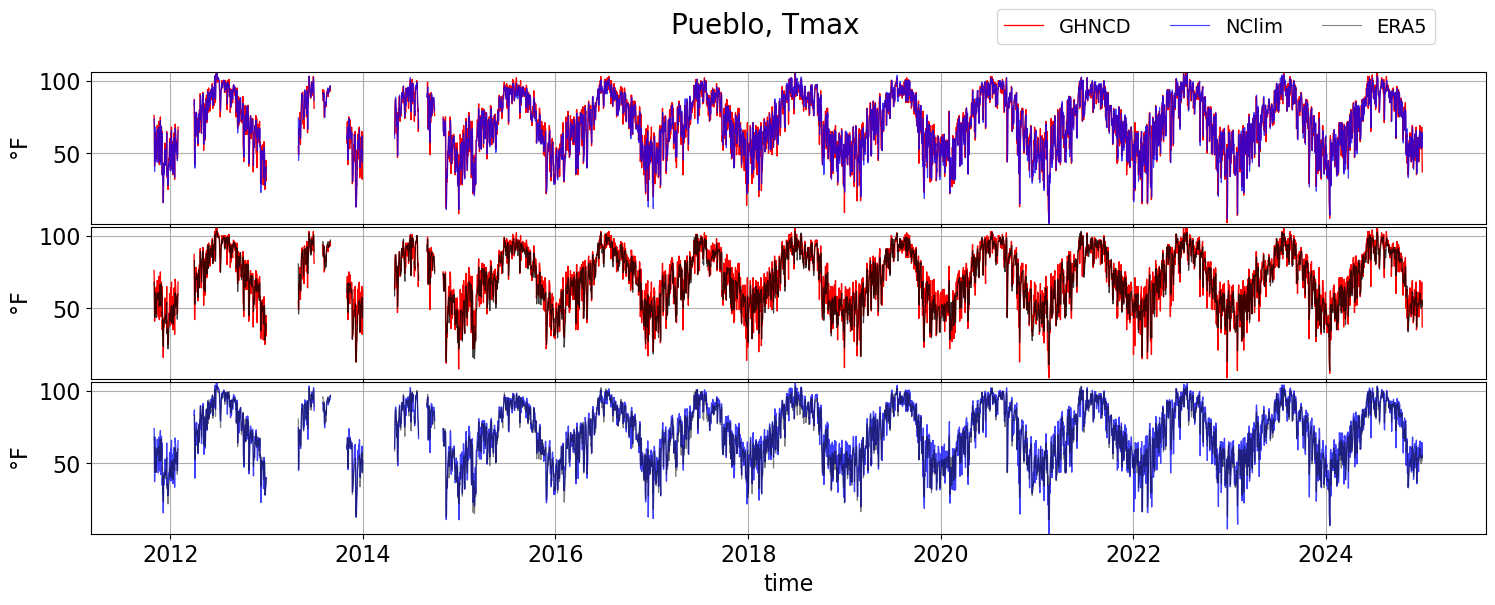

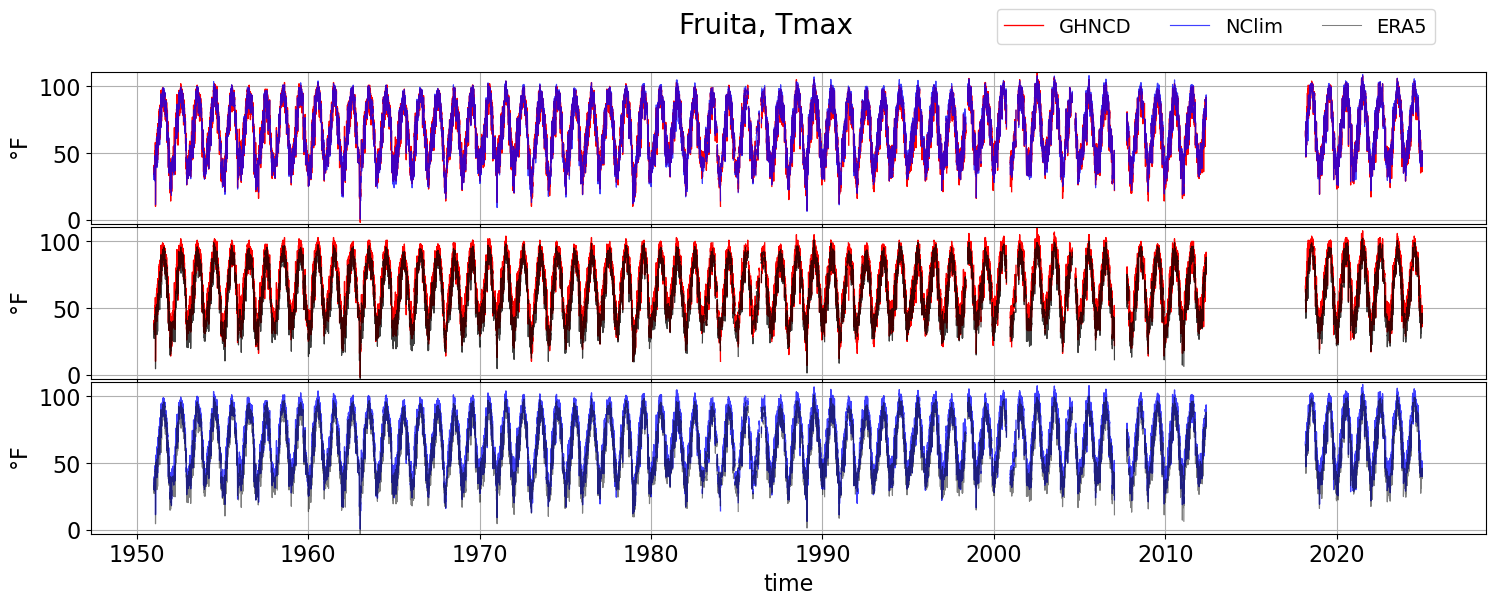

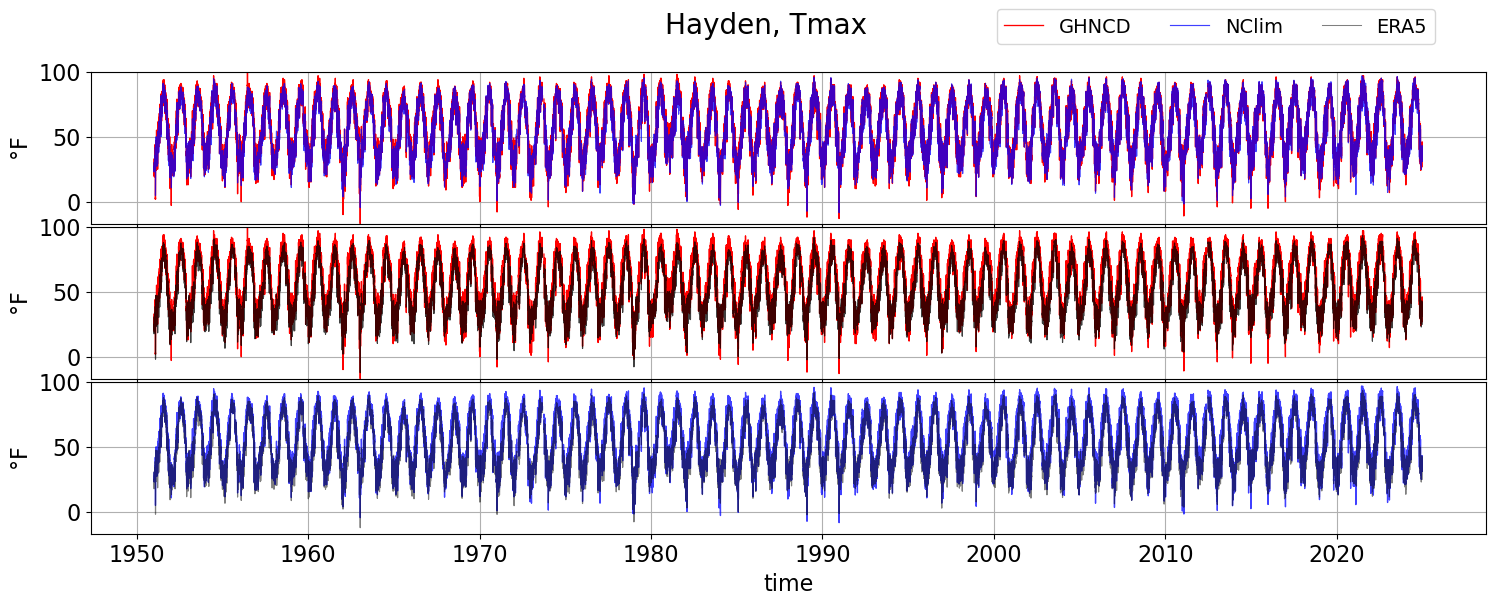

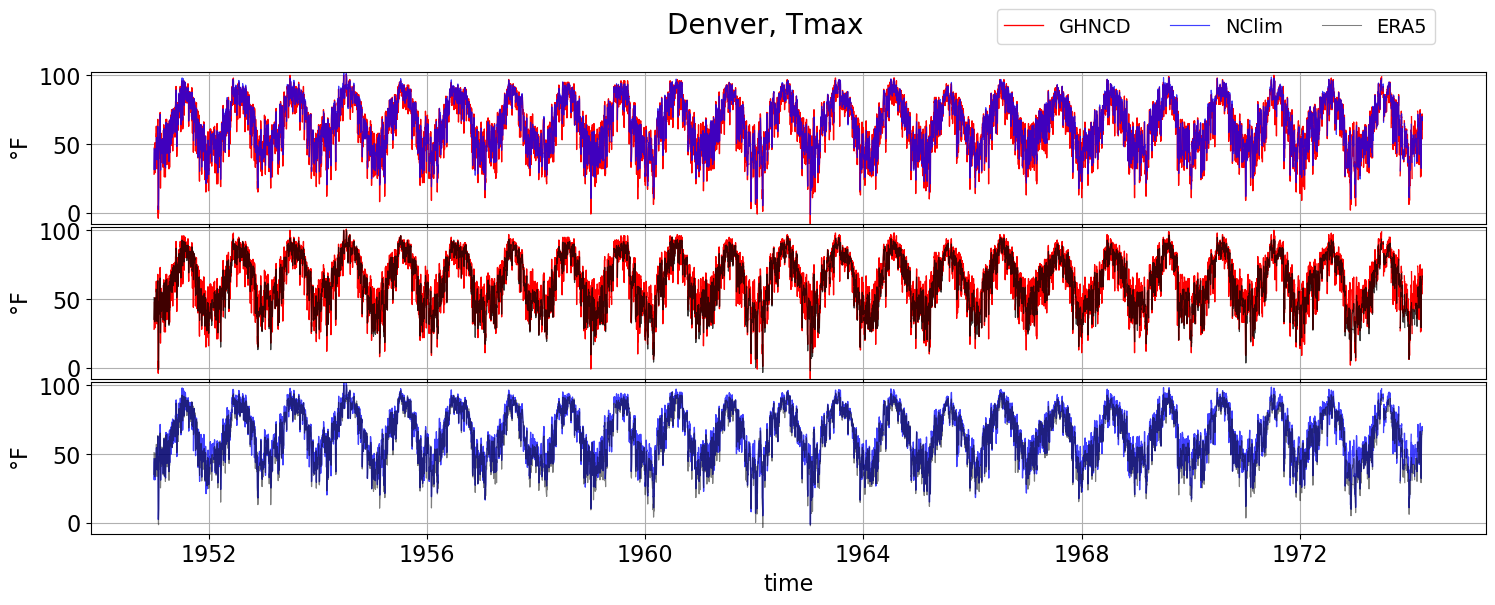

In [91]:
for ip in Tip:
  fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(18,6))
  fig.subplots_adjust(hspace=0.02)
  vmin = min(Otmax.isel(station=ip).min(),Ntmax.isel(station=ip).min(),Etmax.isel(station=ip).min()).data.item()
  vmax = max(Otmax.isel(station=ip).max(),Ntmax.isel(station=ip).max(),Etmax.isel(station=ip).max()).data.item()
  ax[0].plot(ds['time'],Otmax.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  ax[0].plot(ds['time'],Ntmax.isel(station=ip),color='b',linewidth=0.85,label='NClim',alpha=0.75)
  ax[1].plot(ds['time'],Otmax.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  ax[1].plot(ds['time'],Etmax.isel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.75)
  ax[2].plot(ds['time'],Ntmax.isel(station=ip),color='b',linewidth=0.95,label='NClim',alpha=0.75)
  ax[2].plot(ds['time'],Etmax.isel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.5)
  ax[0].set_xticklabels('')
  ax[1].set_xticklabels('')
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  for ix in [0,1,2]:
    ax[ix].set_ylim(vmin,vmax)
    ax[ix].grid()
    ax[ix].tick_params(labelsize=16)
    ax[ix].set_ylabel(units,fontsize=16)   
  plt.xlabel('time',fontsize=16)
  plt.suptitle(f'{Tlabel[ip]}, Tmax',fontsize=20)
  outfile=f'PLOTS/Tmax_daily_ERA5_NClimGrid_CO_'+Tlabel[ip].replace(' ','_')+'.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
  plt.show()